<h1><center>PREDICTING HOUSE SALE PRICES</center></h1> 

![Image](https://365psd.com/images/istock/previews/1024/102465793-modern-city-with-skyscrapers-construction-building-icon-vector-illustration.jpg)

The objective of this project is to use a linear regression algorithm to predict the price a house will be sold in the city of Ames (Iowa, USA).
You can find informations about the different columns here : [data_description](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [1]:
### Importing the librairies we will be working with
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import seaborn as sns
%matplotlib inline

In [2]:
### Reading the dataset
data = pd.read_csv('AmesHousing.tsv', sep="\t")

In [3]:
### To center all our displays
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. DATA CLEANING 

Dealing with missing values is about choosing a threshold. 
**For now**, we will handle missing values using the following rules :   
* **All columns** : drop any columns that contains 5% or more missing values 
* **Text columns** : drop any with 1 or more missing values
* **Numerical columns** : fill in the missing values with the most common value (mode)

## 1.1 Dropping unnecessary columns 

In [4]:
### Dropping column that brings no usueful information for Machine Learning 

**PID** (Parcel identification number) and **Order** (Observation number) are just identification number with no impact on a prediction (in our context). So we can drop them.

In [5]:
data = data.drop(['PID','Order'], axis = 1)

## 1.1 All columns : drop any columns that contains 5% or more missing values

In [6]:
### Number of missing values per column
num_missing = data.isnull().sum() 
num_missing

MS SubClass         0
MS Zoning           0
Lot Frontage      490
Lot Area            0
Street              0
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 80, dtype: int64

In [7]:
### Percentage of missing values per column
pct_missing = ((num_missing/len(data))*100).sort_values(ascending = False) 
pct_missing

Pool QC           99.556314
Misc Feature      96.382253
Alley             93.242321
Fence             80.477816
Fireplace Qu      48.532423
                    ...    
2nd Flr SF         0.000000
1st Flr SF         0.000000
Central Air        0.000000
Sale Condition     0.000000
MS SubClass        0.000000
Length: 80, dtype: float64

In [8]:
### Index of any column with 5% or more missing values
columns_to_drop = pct_missing[(pct_missing >= 0.05)].index 
columns_to_drop

Index(['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu',
       'Lot Frontage', 'Garage Cond', 'Garage Qual', 'Garage Yr Blt',
       'Garage Finish', 'Garage Type', 'Bsmt Exposure', 'BsmtFin Type 2',
       'Bsmt Qual', 'Bsmt Cond', 'BsmtFin Type 1', 'Mas Vnr Type',
       'Mas Vnr Area', 'Bsmt Full Bath', 'Bsmt Half Bath'],
      dtype='object')

In [9]:
### Dropping the columns with 5% or more missing values
data = data.drop(columns_to_drop, axis = 1) 

## 1.2 Text columns : drop any with 1 or more missing values

In [10]:
### Number of missing values in text columns
text_missing = data.select_dtypes(include=['object']).isnull().sum() 

In [11]:
### Text columns with 1 or more missing values
text_columns_to_drop = text_missing[text_missing >=1].index 
text_columns_to_drop

Index(['Electrical'], dtype='object')

In [12]:
### Dropping text columns with 1 or more missing values
data = data.drop(text_columns_to_drop, axis = 1) 

## 1.3 Numerical columns : fill in the missing values with the most common value (mode)

In [13]:
### Selecting numeric columns, ie columns with int or float values
numeric_missing = data.select_dtypes(include = ['int', 'float']).isnull().sum()
numeric_missing

MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        1
Garage Area        1
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
Mo Sold            0
Yr Sold            0
SalePrice          0
dtype: int64

In [14]:
### Columns with values to fill
numeric_missing_fill = numeric_missing[numeric_missing>0].index 
numeric_missing_fill

Index(['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Garage Cars', 'Garage Area'],
      dtype='object')

In [15]:
### Assigning the mode of each column with values to fill to a dictionnary 
replacement_values = data[numeric_missing_fill].mode().to_dict(orient ="records")[0]
replacement_values

{'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0}

In [16]:
### Replacing the missing values in the dataframe
data = data.fillna(replacement_values)

In [17]:
# Checking if there is missing values left
data.isnull().sum().value_counts()

0    59
dtype: int64

# 2. UNDERSTANDING THE TARGET : SalePrice

Since our goal is to predict the SalePrice, lets analyse it to get a better understanding.

In [18]:
### Desscriptive statistics
data['SalePrice'].describe()

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

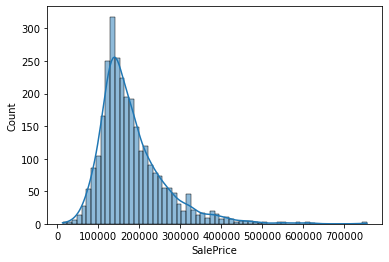

In [19]:
##### Histogram
sns.histplot(data['SalePrice'], kde=True)

The distribution it is positively skewed and have a relatively high kurtosis.

In [20]:
print("Skewness(sk): ",data['SalePrice'].skew())
print("Kurtosis(ku): " ,data['SalePrice'].kurt())

Skewness(sk):  1.7435000757376466
Kurtosis(ku):  5.118899951130896


![Image](https://www.researchgate.net/profile/Attila-Bonyar/publication/298415862/figure/fig1/AS:340236723867648@1458130164255/Illustration-of-the-skewness-and-kurtosis-values-and-how-they-correlate-with-the-shape-of.png)

In [21]:
data["SalePrice"].value_counts().sort_values(ascending = False )

135000    34
140000    33
130000    29
155000    28
145000    26
          ..
327000     1
376162     1
179500     1
187750     1
316500     1
Name: SalePrice, Length: 1032, dtype: int64

# 3. FEATURES SELECTION

## 3.1 Correlation matrix

Correlation with the target (SalePrice) : 
- We will keep only columns with a high correlation (we choose > 0.4, for now).

Correlation between columns (target excluded) :
- When two columns are highly correlated ( > 0.8), we delete one of them to avoid having "duplicated" information.

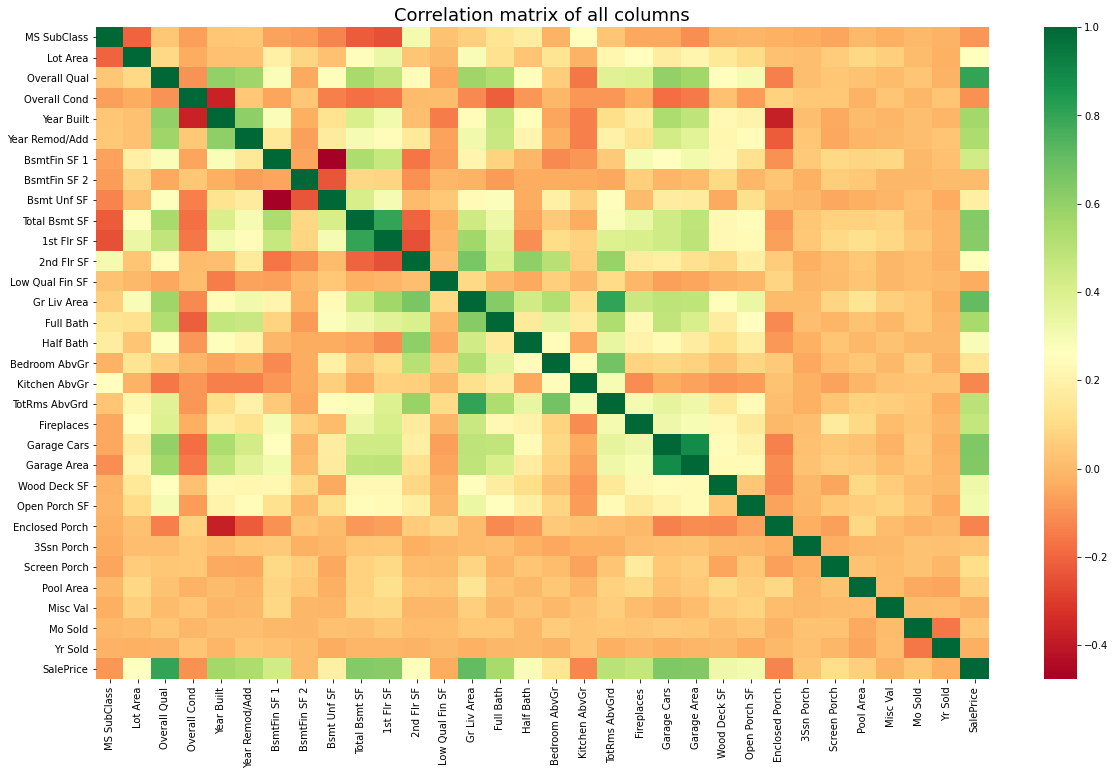

In [22]:
### Correlation matrix between all columns
plt.figure(figsize=(20, 12))
corrmat = sns.heatmap(data.corr(),cmap="RdYlGn")
corrmat.set_title('Correlation matrix of all columns', fontdict={'fontsize':18});

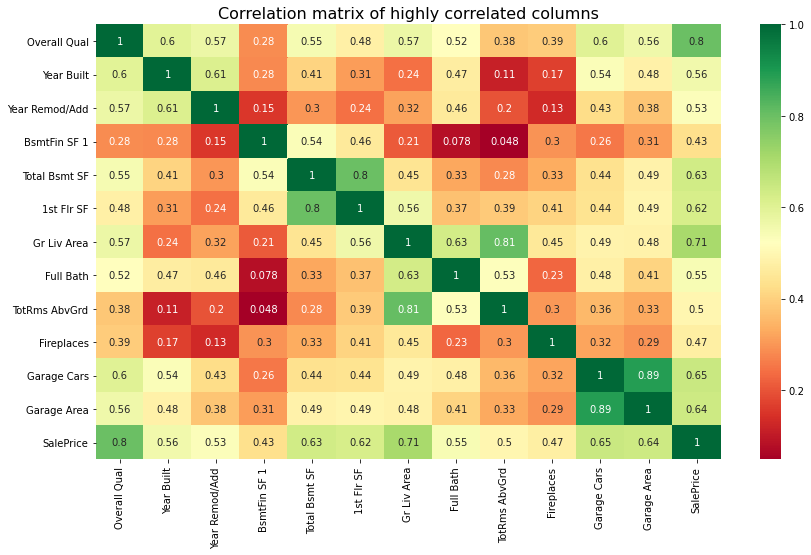

In [23]:
### Zomming on highly correlated columns
corrmat = data.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.4]
plt.figure(figsize=(14,8))
g = sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
g.set_title('Correlation matrix of highly correlated columns', fontdict={'fontsize':16});

With less informations : 

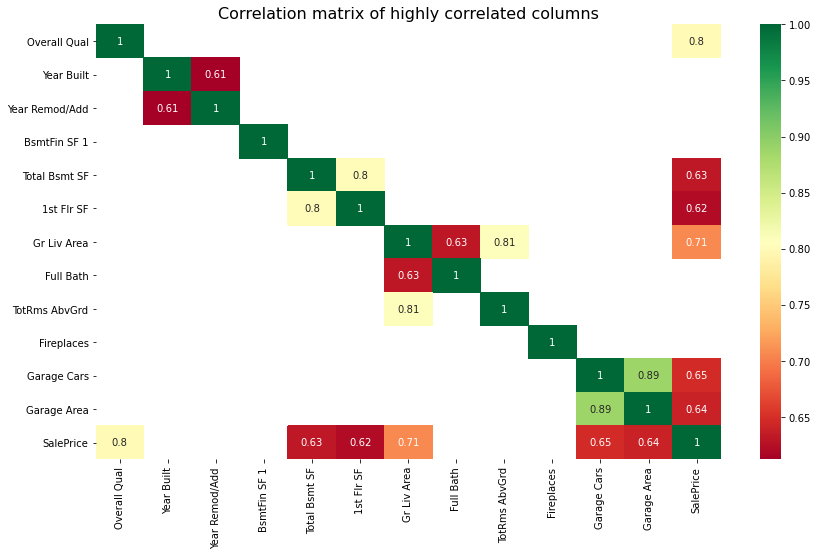

In [24]:
### Zomming on highly correlated columns while masking unnecessary information
corrmat = data.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.4]
plt.figure(figsize=(14,8))
g = sns.heatmap(data[top_corr_features].corr(), annot=True,cmap="RdYlGn", mask = data[top_corr_features].corr() <= 0.6)
g.set_title('Correlation matrix of highly correlated columns', fontdict={'fontsize':16});

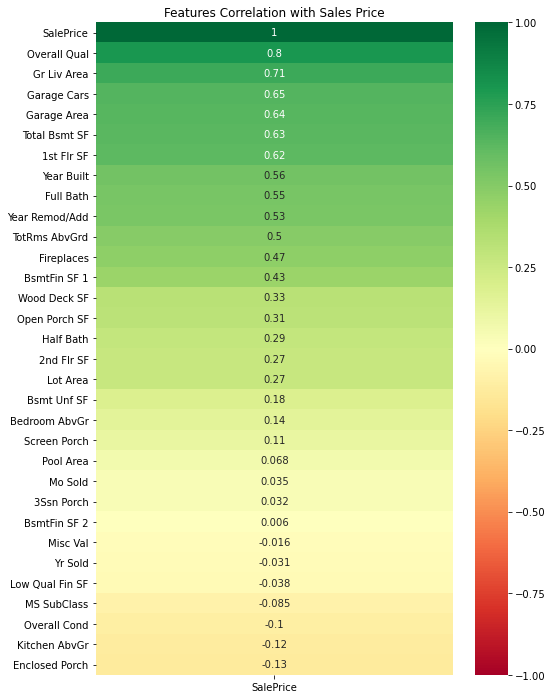

In [25]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), vmin=-1, vmax=1, annot=True,cmap="RdYlGn")
heatmap.set_title('Features Correlation with Sales Price', fontdict={'fontsize':12});

From the correlations matrixes above, we can make these observations : 
- The following columns are highly correlated with SalePrice : **'Overall Qual', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Cars'** and **'Garage Area'**. But some of them are strongly correlated between them, so we have to remove them.
- **'Garage Cars'** and **'Garage Area'** are strongly correlated (0.89), we have to keep only one of them to avoid duplicate -> We will keep **'Garage Cars'** (number of cars you can put in the garage) because it is easier to understand from a buyer point of view and it has the highest correlation with SalePrice.
- **'Total Bsmt SF'** and **'1st Flr SF'** are also highly correlated (0.8). We will keep **'Total Bsmt SF'** because it has the highest correlation with SalePrice.
- **'TotRms AbvGrd'** and **'Gr Liv Area'** have also a high correlation (0.81). We will keep **'Gr Liv Area'** (Above grade living area square feet) because it has the highest correlation with SalePrice.
- Finaly, the remained colums that are highly correlated columns with SalePrice are : **'Overall Qual', 'Total Bsmt SF', 'Gr Liv Area'** and **'Garage Cars'**. These are the features we will select.
    

In [26]:
### Dropping the columns : 
data = data.drop(['1st Flr SF','Garage Area'], axis = 1)

Lets dig a little more into the relationshipip between the selected features and SalePrice by visualizing some scatter plots : 

## 3.2 Scatter plots

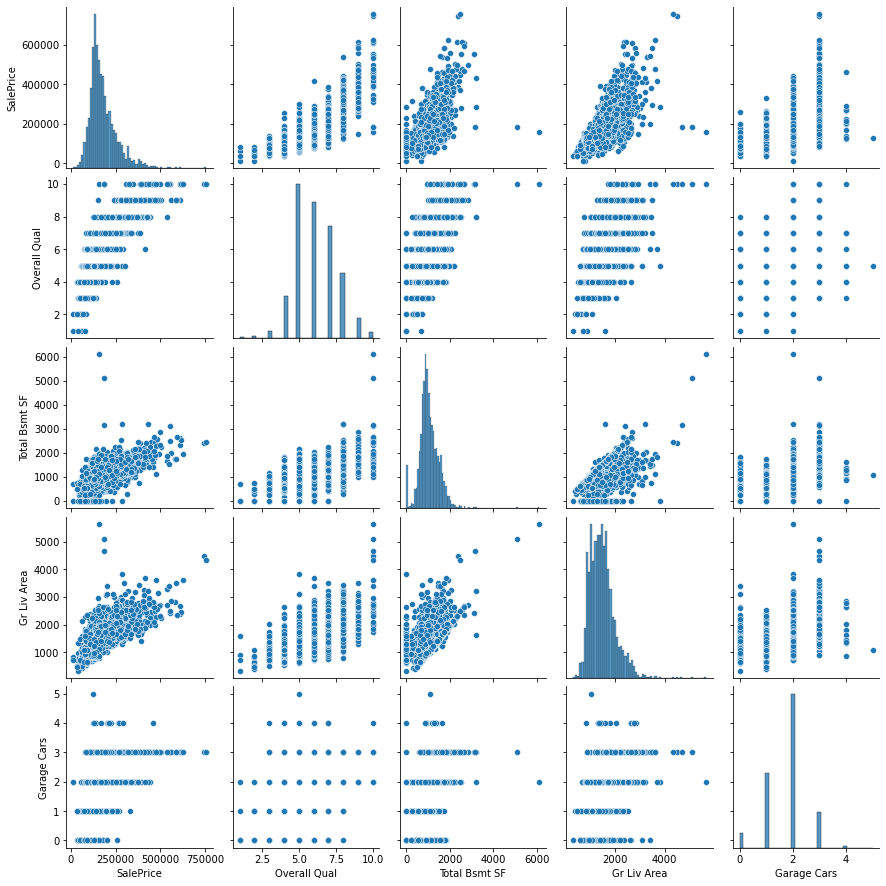

In [27]:
cols = ['SalePrice', 'Overall Qual','Total Bsmt SF', 'Gr Liv Area', 'Garage Cars']
sns.pairplot(data[cols])

## 3.3 Categorical columns

By reading the documentation, we can identify the following colums are nominal : 

In [28]:
nominal_features = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [29]:
### Checking if there is no nominal features in data:
transform_cat_cols = []
for col in nominal_features:
    if col in data:
        transform_cat_cols.append(col)
transform_cat_cols

['MS SubClass',
 'MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air',
 'Sale Type',
 'Sale Condition']

In [30]:
### Checking the number of unique values in each categorical column
unique_values_count = data[transform_cat_cols].apply(lambda col : len(col.unique())).sort_values()
unique_values_count

Street             2
Central Air        2
Land Contour       4
Lot Config         5
Bldg Type          5
Sale Condition     6
Heating            6
Foundation         6
Roof Style         6
MS Zoning          7
Roof Matl          8
House Style        8
Condition 2        8
Condition 1        9
Sale Type         10
Exterior 1st      16
MS SubClass       16
Exterior 2nd      17
Neighborhood      28
dtype: int64

In [31]:
# Aribtrary cutoff of 10 unique values 
drop_nonuniq_cols = unique_values_count[unique_values_count > 10].index
data = data.drop(drop_nonuniq_cols, axis=1)

In [32]:
# Select just the remaining text columns and convert to categorical
text_cols = data.select_dtypes(include=['object'])
for col in text_cols:
    data[col] = data[col].astype('category')

In [33]:
# Create dummy columns and add back to the dataframe!
data = pd.concat([
    data, 
    pd.get_dummies(data.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

# 4. Predictions

In [34]:
from my_functions import train_and_test # See 'my_functions' file for more details about train_and_test
rmse = train_and_test(data, k=5)

[40642.7614973483, 39739.46554107414, 27705.960697331528, 27686.002339074654, 27452.80510523059]
